In [11]:
%reset
###--- import packages
import nilearn, scipy, os, bct
from nilearn import input_data, signal, plotting
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [13]:
###--- Import resting state ".nii" files - list of locations
MainDir = '/home/connectomics/LearningBrain'
rest_filenames = []
for dirpath, dirnames, filenames in os.walk(MainDir):
    for filename in filenames:
        if ('rest_bold_space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz' in filename) and (MainDir)+'/derivatives/fmriprep/sub' in os.path.join(dirpath, filename):
            rest_filenames.append(os.path.join(dirpath, filename))
print('number of rest connectivity files is equal ' +str(len(rest_filenames)))
rest_filenames.sort()
[print(file) for file in rest_filenames[:3]]

###--- Import dual n-back *nii files - list of locations
dual_filenames = []
for dirpath, dirnames, filenames in os.walk(MainDir):
    for filename in filenames:
        if ('dualnback_bold_space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz' in filename) and (MainDir)+'/derivatives/fmriprep/sub'  in os.path.join(dirpath, filename):
            dual_filenames.append(os.path.join(dirpath, filename))
print('number of dual n-back connectivity files is equal ' +str(len(dual_filenames)))
dual_filenames.sort()
[print(file) for file in dual_filenames[:3]]

###--- Import resting state confounds list.
rest_confounds = []
for dirpath, dirnames, filenames in os.walk(MainDir):
    for filename in filenames:
        if ('rest_bold_confounds.tsv' in filename) and (MainDir)+'/derivatives/fmriprep/sub' in os.path.join(dirpath, filename):
            rest_confounds.append(os.path.join(dirpath, filename))
rest_confounds.sort()
print('number of confound files is equal ' +str(len(rest_confounds)))
[print(file) for file in rest_confounds[:3]]

###--- Import functional task data confounds list.
func_confounds = []
for dirpath, dirnames, filenames in os.walk(MainDir):
    for filename in filenames:
        if ('dualnback_bold_confounds.tsv' in filename) and (MainDir)+'/derivatives/fmriprep/sub' in os.path.join(dirpath, filename):
            func_confounds.append(os.path.join(dirpath, filename))
func_confounds.sort()
print('number of confound files is equal ' +str(len(func_confounds)))
[print(file) for file in func_confounds[:3]]

###--- Create masks for 1-back, 2-back and instruction (only relevant for task data)
#--- vector_n_back[:,0] - 1back, vector_n_back[:,1] - 2back, vector_n_back[:,2] - instruction
onsets_1_back = np.array([4, 72, 140, 208, 276, 344, 412, 480, 548, 616])
onsets_2_back = np.array([38, 106, 174, 242, 310, 378, 446, 514, 582, 650])
TR = 2
duration = 30
vector_n_back = np.zeros((340,3))

for i in range(len(vector_n_back)):
   if i in onsets_1_back/TR:
      for k in range(int(duration/TR)):
        vector_n_back[i+k,0] = 1
   if i in onsets_2_back/TR:
      for k in range(int(duration/TR)):
        vector_n_back[i+k,1] = 1   
   else:
       continue 

for i in range(len(vector_n_back)):
    if (vector_n_back[i,0] == 0) and (vector_n_back[i,1] == 0):
        vector_n_back[i,2] = 1   
        
vector_n_back=vector_n_back.astype(bool)              
print(vector_n_back)


number of rest connectivity files is equal 107
/home/connectomics/LearningBrain/derivatives/fmriprep/sub-01/ses-1/func/sub-01_ses-1_task-rest_bold_space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz
/home/connectomics/LearningBrain/derivatives/fmriprep/sub-01/ses-2/func/sub-01_ses-2_task-rest_bold_space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz
/home/connectomics/LearningBrain/derivatives/fmriprep/sub-01/ses-3/func/sub-01_ses-3_task-rest_bold_space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz
number of dual n-back connectivity files is equal 108
/home/connectomics/LearningBrain/derivatives/fmriprep/sub-01/ses-1/func/sub-01_ses-1_task-dualnback_bold_space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz
/home/connectomics/LearningBrain/derivatives/fmriprep/sub-01/ses-2/func/sub-01_ses-2_task-dualnback_bold_space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz
/home/connectomics/LearningBrain/derivatives/fmri

In [14]:
###--- DEFINE SET OF HYPERPARAMETERS
#--- Connectivity measures
models = ['partial correlation', 'tangent', 'covariance','precision']

#--- Atlases
power = nilearn.datasets.fetch_coords_power_2011()
dosenbach = nilearn.datasets.fetch_coords_dosenbach_2010()
multiscale = nilearn.datasets.fetch_atlas_basc_multiscale_2015()
aal = nilearn.datasets.fetch_atlas_aal()
harvard = nilearn.datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr0-1mm',symmetric_split=True)

coords_power = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T
pow_masker = nilearn.input_data.NiftiSpheresMasker(seeds=coords_power, radius=3, standardize=True, detrend=True)
print(power['rois'][:8])

coords_dosenbach = np.vstack((dosenbach.rois['x'], dosenbach.rois['y'], dosenbach.rois['z'])).T
dos_masker = nilearn.input_data.NiftiSpheresMasker(seeds=coords_dosenbach, radius=3, standardize=True, detrend=True)
print(dosenbach['rois'][:8])

har_masker = nilearn.input_data.NiftiLabelsMasker(labels_img = harvard.maps, standardize=True, detrend=True)
aal_masker = nilearn.input_data.NiftiLabelsMasker(labels_img = aal.maps, standardize=True, detrend=True)
mul_masker = nilearn.input_data.NiftiLabelsMasker(labels_img = multiscale.scale197, standardize=True, detrend=True)

maskers = [pow_masker, dos_masker, mul_masker, aal_masker, har_masker]
masker_names=['pow','dos','mul','aal','har']

[(1, -25, -98, -12) (2,  27, -97, -13) (3,  24,  32, -18)
 (4, -56, -45, -24) (5,   8,  41, -24) (6, -21, -22, -20)
 (7,  17, -28, -17) (8, -37, -29, -26)]
[( 18, -81, -33) (-21, -79, -33) ( -6, -79, -33) ( 33, -73, -30)
 (-34, -67, -29) ( 32, -61, -31) (-25, -60, -34) (-37, -54, -37)]


/home/connectomics/.local/lib/python3.6/site-packages/numpy/lib/npyio.py:2278: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [15]:
###--- Choose the data to work on (only resting-state)
func_filenames = rest_filenames
confounds = rest_confounds

#--- choose only the important regressors (CSF, White Matter, Linear Trend) and save new confounds file
for file,confound in zip(func_filenames,confounds):
    conf=pd.read_csv(confound,delimiter='\t')
    conf=conf[conf.filter(regex='WhiteMatter|CSF|CompCor|X|Y|Z').columns]
    print(conf.columns)
    np.savetxt(confound[:-4]+'_edited.csv',conf,delimiter=',')

Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCom

Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCom

Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCom

Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCompCor02', 'aCompCor03', 'aCompCor04', 'aCompCor05', 'X', 'Y', 'Z',
       'RotX', 'RotY', 'RotZ'],
      dtype='object')
Index(['CSF', 'WhiteMatter', 'tCompCor00', 'tCompCor01', 'tCompCor02',
       'tCompCor03', 'tCompCor04', 'tCompCor05', 'aCompCor00', 'aCompCor01',
       'aCom

In [17]:
for file,confound in zip(func_filenames,confounds):
    for model in models: #models:
        for masker, masker_name in zip(maskers, masker_names):
            ###--- create time-series in all ROIs and apply filters
            time_series_power = masker.fit_transform(file, confounds=confound[:-4]+'_edited.csv')
            time_series_power_filtered=signal.clean(time_series_power,low_pass=0.08,high_pass=0.009)
            ###--- create the connectivity matrices
            correlation_measure = ConnectivityMeasure(kind = model)
            correlation_matrix_raw = correlation_measure.fit_transform([time_series_power_filtered])[0]
            # Mask the main diagonal:
            np.fill_diagonal(correlation_matrix_raw, 0)
            # Transform matrix into vector and apply z-score
            indices = np.triu_indices_from(correlation_matrix_raw,k=1)
            correlation_vec = np.asarray(correlation_matrix_raw[indices])
            zscore = scipy.stats.zscore(correlation_vec)
            correlation_matrix = np.zeros((len(correlation_matrix_raw),len(correlation_matrix_raw)))      
            correlation_matrix[indices]=correlation_vec
            correlation_matrix = correlation_matrix + correlation_matrix.T
            #######--- SAVE RESULTS
            #--- extract sub number from file name 
            sub = int(file[file.find('sub-')+4:file.find('sub-')+6])
            #--- extract session number from file name
            sess = int(file[file.find('ses-')+4:file.find('ses-')+5])
            # plotting matrices to files
            display = plotting.plot_matrix(correlation_matrix, vmin=-0.8, vmax=0.8, colorbar=True)    
            display.figure.savefig('matKFLB_sub'+'{:02d}'.format(sub)+ '_ses' + str(sess) + '_' + masker_name[:3] + '_' + model[:3] + '.png')     
            plt.clf()
            plt.hist(np.ravel(correlation_matrix), bins=100)
            plt.savefig('matKFLB_sub'+'{:02d}'.format(sub)+ '_ses' + str(sess) + '_' + masker_name[:3] + '_' + model[:3] + 'histogram.png')
            plt.clf()
            #--- save time-series
            #TimeSeriesAll[sub,sess,1,:150,:]=time_series_power_filtered[vector_n_back[:,0]]
            #TimeSeriesAll[sub,sess,2,:150,:]=time_series_power_filtered[vector_n_back[:,1]]
            #--- save connectivity matrix as human-readable data and images
            np.savetxt('matKFLB_sub'+'{:02d}'.format(sub)+ '_ses' + str(sess) + '_' + masker_name[:3] + '_' + model[:3] + '.txt', correlation_matrix)
            print('Subject ' + str(sub) + ', session ' + str(sess) + ', model: '+ str(model) +' and atlas: '+str(masker_name)+' complete.')

/home/connectomics/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Subject 1, session 1, model: partial correlation and atlas: pow complete.


/home/connectomics/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Subject 1, session 1, model: partial correlation and atlas: dos complete.


/home/connectomics/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Subject 1, session 1, model: partial correlation and atlas: mul complete.


/home/connectomics/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Subject 1, session 1, model: partial correlation and atlas: aal complete.


/home/connectomics/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Subject 1, session 1, model: partial correlation and atlas: har complete.


/home/connectomics/.local/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


ValueError: Tangent space parametrization can only be applied to a group of subjects, as it returns deviations to the mean. You provided [array([[-0.02334126,  0.04682624, -0.01217784, ...,  0.00775108,
         0.11254569,  0.08165316],
       [-0.86844919, -0.56660579, -1.11412299, ..., -0.24579099,
         0.84981763,  0.07816297],
       [-1.28348796, -0.72187609, -1.72697438, ..., -0.30074845,
         0.98851765,  0.30831859],
       ...,
       [ 3.94039488,  2.44579837,  2.74066238, ...,  0.03293011,
        -2.17004107, -1.11525482],
       [ 2.88246401,  1.55582157,  1.79341736, ..., -0.59157091,
        -1.41693017, -0.30035215],
       [-0.19248588, -0.10140211, -0.21250013, ..., -0.12466275,
        -0.12275831, -0.07946127]])]

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

<Figure size 504x360 with 0 Axes>

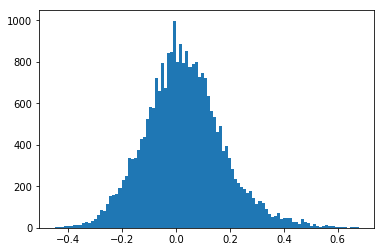

In [41]:
###--- Check histogram of calculated data

plt.hist(np.ravel(correlation_matrix), bins=100)
plt.savefig('matKFLB_sub'+'{:02d}'.format(sub)+ '_ses' + str(sess) + '_' + masker_name[:3] + '_' + model[:3] + 'histogram.png')
            

In [31]:


correlation_matrix_raw=np.array([[1,2,3,1,2,3],[4,5,6,4,5,6],[7,8,9,7,8,9],[1,2,3,1,2,3],[4,5,6,4,5,6],[7,8,9,7,8,9]])
print(correlation_matrix_raw)
indices = np.triu_indices_from(correlation_matrix_raw,k=1)
print(indices)
correlation_vec = np.asarray(correlation_matrix_raw[indices])
print(correlation_vec)
correlation_matrix=np.zeros((len(correlation_matrix_raw),len(correlation_matrix_raw)))
correlation_matrix[indices]=correlation_vec
correlation_matrix = correlation_matrix + correlation_matrix.T
print(correlation_matrix)


[[1 2 3 1 2 3]
 [4 5 6 4 5 6]
 [7 8 9 7 8 9]
 [1 2 3 1 2 3]
 [4 5 6 4 5 6]
 [7 8 9 7 8 9]]
(array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4]), array([1, 2, 3, 4, 5, 2, 3, 4, 5, 3, 4, 5, 4, 5, 5]))
[2 3 1 2 3 6 4 5 6 7 8 9 2 3 6]
[[0. 2. 3. 1. 2. 3.]
 [2. 0. 6. 4. 5. 6.]
 [3. 6. 0. 7. 8. 9.]
 [1. 4. 7. 0. 2. 3.]
 [2. 5. 8. 2. 0. 6.]
 [3. 6. 9. 3. 6. 0.]]
('/home/miriam/LearningBrain/derivatives/fmriprep/sub-01/ses-1/func/sub-01_ses-1_task-rest_bold_space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz', '/home/miriam/LearningBrain/derivatives/fmriprep/sub-01/ses-1/func/sub-01_ses-1_task-rest_bold_confounds.tsv')
